# Digit Recognizer - Classification using SVM

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

Goal is to correctly identify digits from a dataset of tens of thousands of handwritten image

In this notebook, we'll explore the popular Digit Recognizer dataset and build an SVM model to classify handwritten digits.

### The solution is divided into the following sections:
- Data understanding and exploration
- Data Analysis.
- Data preparation.
- Model building.
- Prediction and Model evaluation.

## Data understanding and exploration 

In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,recall_score,precision_score

from sklearn import svm
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from scipy.stats import boxcox


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset
data = pd.read_csv("../data/train.csv")
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Checking the dataframe size to understand what amount of data we are dealing with
data.shape

(42000, 785)

In [4]:
# Doing describe to check the spread of values across all numerical fields
data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


## Data Analysis

In [5]:
# Retrieving the 4th row that is index 3 and considering all columns except 1st as generally the 1st column contains 
# no significant pixel data
four = data.iloc[3,1:]
four.shape

(784,)

In [6]:
# Reshaping the data into 28x28 array of pixels
four = four.values.reshape(28, 28)

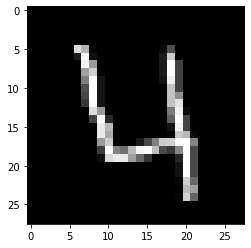

In [7]:
# Using imshow function from matplotlib plt to display the 28X28 array pixel data
plt.imshow(four, cmap='gray')

In [8]:
# Printing the 28X28 array and we see different pixel values, the one with 0 means no data, we see numeric 4 appearing
print(four[5:-5, 5:-5])

[[  0 220 179   6   0   0   0   0   0   0   0   0   9  77   0   0   0   0]
 [  0  28 247  17   0   0   0   0   0   0   0   0  27 202   0   0   0   0]
 [  0   0 242 155   0   0   0   0   0   0   0   0  27 254  63   0   0   0]
 [  0   0 160 207   6   0   0   0   0   0   0   0  27 254  65   0   0   0]
 [  0   0 127 254  21   0   0   0   0   0   0   0  20 239  65   0   0   0]
 [  0   0  77 254  21   0   0   0   0   0   0   0   0 195  65   0   0   0]
 [  0   0  70 254  21   0   0   0   0   0   0   0   0 195 142   0   0   0]
 [  0   0  56 251  21   0   0   0   0   0   0   0   0 195 227   0   0   0]
 [  0   0   0 222 153   5   0   0   0   0   0   0   0 120 240  13   0   0]
 [  0   0   0  67 251  40   0   0   0   0   0   0   0  94 255  69   0   0]
 [  0   0   0   0 234 184   0   0   0   0   0   0   0  19 245  69   0   0]
 [  0   0   0   0 234 169   0   0   0   0   0   0   0   3 199 182  10   0]
 [  0   0   0   0 154 205   4   0   0  26  72 128 203 208 254 254 131   0]
 [  0   0   0   0  61 254

In [9]:
# Retrieving the 3rd row that is index 2 and considering all columns except 1st as generally the 1st column contains 
# no significant pixel data
one = data.iloc[2,1:]
one.shape

(784,)

In [10]:
# Reshaping the data into 28x28 array of pixels
one = one.values.reshape(28, 28)

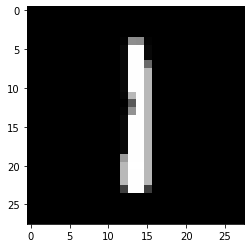

In [11]:
# Using imshow function from matplotlib plt to display the 28X28 array pixel data
plt.imshow(one, cmap='gray')

In [12]:
# Checking the distribution of labels in the dataset
data['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

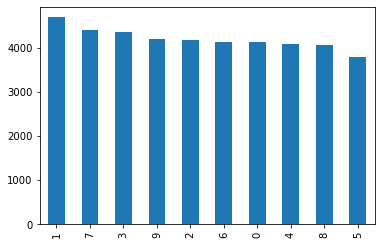

In [13]:
# Plotting the above data in bar to visualize it better, we
data['label'].value_counts().plot.bar()

In [14]:
# Checking the percentage of each labels across the entire dataset
round(data['label'].value_counts()/len(data.index)*100,2)

1    11.15
7    10.48
3    10.36
9     9.97
2     9.95
6     9.85
0     9.84
4     9.70
8     9.67
5     9.04
Name: label, dtype: float64

In [15]:
# Checking for the presence of any missing values
data.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [16]:
# Doing describe to check the spread of values across all numerical fields
data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


## Data preparation

In [17]:
# Checking for presence of any column other than numeric type
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
list(data.select_dtypes(exclude=numerics).columns)

[]

In [18]:
# Dividing the entire data into X and y that is all independent feature into X and dependent feature to y
X = data
y = data.pop('label')

In [19]:
# splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=42)

In [20]:
# splitting the test set into further test and validation set
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,train_size=0.9,random_state=42)

In [21]:
# Applying Standard scaler to bring all features to same scale as we see lot of variations across features currently
scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

## Model building

### Linear SVM

In [22]:
# an initial SVM model with linear kernel   
svm_linear = svm.SVC(kernel='linear')

# fitting on the train set
svm_linear.fit(X_train_scaled, y_train)

SVC(kernel='linear')

In [23]:
# Predicting on the test set
y_test_pred = svm_linear.predict(X_test_scaled)
y_test_pred[:10]

array([7, 0, 8, 3, 1, 4, 5, 3, 4, 4], dtype=int64)

In [24]:
# Printing confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
confusion

array([[3259,    0,    7,    5,   15,   25,   20,    5,   12,    0],
       [   1, 3707,   13,   13,   11,    3,    4,    5,   32,    3],
       [  50,   49, 2973,   62,   63,   14,   51,   46,   53,   11],
       [  19,   23,  107, 3119,   13,  114,   19,   17,   79,   46],
       [   4,    6,   26,    5, 3010,    6,   17,   15,   14,  173],
       [  54,   29,   19,  160,   45, 2633,   44,    3,   88,   15],
       [  58,   11,   44,    4,   43,   34, 3118,    3,   21,    0],
       [  12,   32,   35,   21,   78,   13,    0, 3219,   10,  131],
       [  36,   75,   57,  117,   24,  127,   18,   22, 2783,   56],
       [  21,   16,   12,   46,  182,   29,    1,  139,   24, 2914]],
      dtype=int64)

In [25]:
# Checking for Accuracy on test set
round(metrics.accuracy_score(y_test, y_test_pred),2)*100

0.9034391534391535

In [26]:
# class-wise accuracy on Test set
class_wise = metrics.classification_report(y_test, y_test_pred)
print(class_wise)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3348
           1       0.94      0.98      0.96      3792
           2       0.90      0.88      0.89      3372
           3       0.88      0.88      0.88      3556
           4       0.86      0.92      0.89      3276
           5       0.88      0.85      0.86      3090
           6       0.95      0.93      0.94      3336
           7       0.93      0.91      0.92      3551
           8       0.89      0.84      0.87      3315
           9       0.87      0.86      0.87      3384

    accuracy                           0.90     34020
   macro avg       0.90      0.90      0.90     34020
weighted avg       0.90      0.90      0.90     34020



### Non-Linear SVM

In [27]:
# rbf kernel with other hyperparameters kept to default 
svm_rbf = svm.SVC(kernel='rbf')

# Fitting on train data
svm_rbf.fit(X_train_scaled, y_train)

SVC()

In [28]:
# Predicting on test set
y_test_pred = svm_rbf.predict(X_test_scaled)
y_test_pred[:10]

array([7, 0, 8, 3, 1, 4, 5, 2, 4, 4], dtype=int64)

In [29]:
# Printing confusion matric
confusion = metrics.confusion_matrix(y_test, y_test_pred)
confusion

array([[3244,    0,   47,    6,    6,    9,   26,    2,    8,    0],
       [   0, 3696,   31,    9,    7,    8,   13,    4,   18,    6],
       [  20,   11, 3146,   39,   35,    4,   23,   44,   44,    6],
       [  13,   16,  139, 3165,    5,   67,    5,   44,   72,   30],
       [   4,   11,   78,    2, 2983,    8,   20,   14,    8,  148],
       [  26,    8,  106,   98,   24, 2697,   66,    9,   38,   18],
       [  29,    4,  126,    0,   23,   37, 3104,    0,   13,    0],
       [   3,   26,  135,    3,   40,    3,    0, 3236,    8,   97],
       [  21,   36,   80,   49,   19,   64,   20,   13, 2969,   44],
       [  17,   12,   83,   47,   78,   11,    0,  109,   21, 3006]],
      dtype=int64)

In [30]:
# Checkingfor Accuracy on test set
round(metrics.accuracy_score(y_test, y_test_pred),2)*100

0.9184597295708407

In [31]:
# class-wise accuracy on test set
class_wise = metrics.classification_report(y_test, y_test_pred)
print(class_wise)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3348
           1       0.97      0.97      0.97      3792
           2       0.79      0.93      0.86      3372
           3       0.93      0.89      0.91      3556
           4       0.93      0.91      0.92      3276
           5       0.93      0.87      0.90      3090
           6       0.95      0.93      0.94      3336
           7       0.93      0.91      0.92      3551
           8       0.93      0.90      0.91      3315
           9       0.90      0.89      0.89      3384

    accuracy                           0.92     34020
   macro avg       0.92      0.92      0.92     34020
weighted avg       0.92      0.92      0.92     34020



### Hyperparameter Tuning of the Non Linear SVM

In [33]:
# conduct (grid search) cross-validation to find the optimal values 
# of cost C and the optimal value for degree of non linearity using gamma

folds = KFold(n_splits=2, shuffle=True,random_state=100)

parameters = {'C':[0.01,0.1, 1, 10, 100, 1000], 
             'gamma': [0.0001, 0.001, 0.01, 0.1]}

# instantiate a model 
svc_grid_search = svm.SVC(kernel="rbf")

# create a classifier to perform grid search
clf = GridSearchCV(estimator = svc_grid_search,
                   cv = folds,
                   param_grid=parameters,
                   scoring='accuracy',
                   n_jobs=-1,
                   verbose=True,
                   return_train_score=True)

# fit
clf.fit(X_val_scaled, y_val)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  3.8min finished


GridSearchCV(cv=KFold(n_splits=2, random_state=100, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1]},
             return_train_score=True, scoring='accuracy', verbose=True)

In [34]:
# Moving the results to a dataframe
cv_results = pd.DataFrame(clf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,19.806629,0.353056,11.337692,0.134141,0.01,0.0001,"{'C': 0.01, 'gamma': 0.0001}",0.096825,0.110053,0.103439,0.006614,20,0.119577,0.117989,0.118783,0.000794
1,20.009085,0.541553,11.334956,0.156336,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",0.096825,0.110053,0.103439,0.006614,20,0.119577,0.117989,0.118783,0.000794
2,20.593522,0.033910,11.504758,0.023437,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.096825,0.110053,0.103439,0.006614,20,0.119577,0.117989,0.118783,0.000794
3,20.556874,0.100984,11.382331,0.045622,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.096825,0.110053,0.103439,0.006614,20,0.119577,0.117989,0.118783,0.000794
4,20.081384,0.168051,10.942186,0.130652,0.1,0.0001,"{'C': 0.1, 'gamma': 0.0001}",0.254497,0.217460,0.235979,0.018519,14,0.272487,0.228571,0.250529,0.021958
5,15.239839,0.064329,10.112422,0.178025,0.1,0.001,"{'C': 0.1, 'gamma': 0.001}",0.786772,0.789947,0.788360,0.001587,9,0.813757,0.810053,0.811905,0.001852
6,19.836034,0.116189,10.508847,0.060338,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.203175,0.188360,0.195767,0.007407,15,0.215873,0.215873,0.215873,0.000000
7,20.572553,0.003990,11.612390,0.043884,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.096825,0.110053,0.103439,0.006614,20,0.119577,0.117989,0.118783,0.000794
8,11.980929,0.346570,10.314896,0.103722,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.844444,0.862434,0.853439,0.008995,8,0.877778,0.888360,0.883069,0.005291
9,8.664052,0.114961,8.424194,0.066054,1,0.001,"{'C': 1, 'gamma': 0.001}",0.895767,0.895238,0.895503,0.000265,7,0.977249,0.972487,0.974868,0.002381


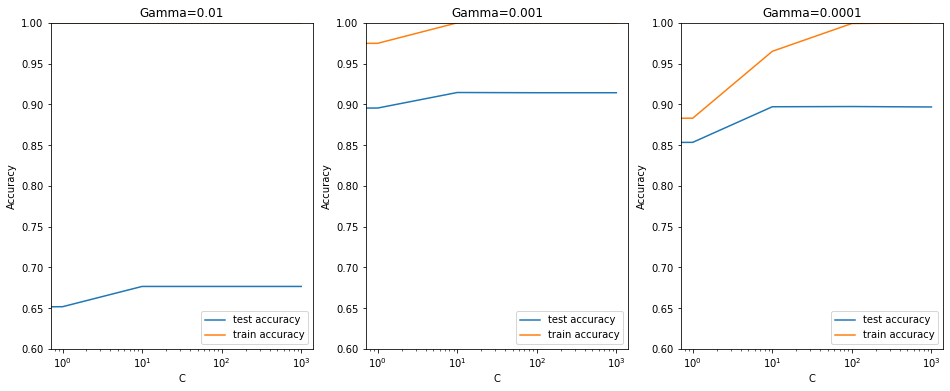

In [35]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

plt.show()

In [36]:
# Printing the best score that we can get using the hyperparameters
print('We can get score of :',clf.best_score_,' using',clf.best_params_)

We can get score of : 0.9145502645502646  using {'C': 10, 'gamma': 0.001}


### Fit the Non Linear SVM Model on the Selected Hyper Parameter

In [37]:
# optimal hyperparameters
best_C = 10
best_gamma = 0.001

# model
svmRBF_final = svm.SVC(kernel='rbf', C=best_C, gamma=best_gamma)

# fitting on the train set
svmRBF_final.fit(X_train_scaled,y_train)

SVC(C=10, gamma=0.001)

In [38]:
# predicting on the test set
y_test_pred = svmRBF_final.predict(X_test_scaled)

In [39]:
# evaluation: CM 
confusion = metrics.confusion_matrix(y_test, y_test_pred)

# measure accuracy
test_accuracy = round(metrics.accuracy_score(y_test, y_test_pred),2)*100

# Accuracy on test set
print("Test Accuracy : ",test_accuracy, "\n")
print(confusion)

0.9276601998824221 

[[3263    0   29    4    7   10   24    1   10    0]
 [   0 3703   26   10   12    3    9    6   20    3]
 [  20   13 3143   31   29    6   28   50   42   10]
 [  13   13  121 3216    8   69    5   26   53   32]
 [   4    6   52    2 3039   11   22    7    9  124]
 [  30    9   66   97   24 2729   60    4   57   14]
 [  36    6  101    0   23   33 3124    3   10    0]
 [   3   24  117    5   54    5    0 3262    7   74]
 [  22   42   56   55   18   46   17   12 3006   41]
 [  14   11   58   37   72   14    0   85   19 3074]]


### The linear SVM is giving us Test Accuracy of 90%
### The Non Linear SVM with default hyperparameters is giving us Test Accuracy of 92%
### The Non Linear SVM with optimal hyperparameters is giving us Test Accuracy of 93%

## Now lets proceed with the preparation for the final submission. 
## First lets do the data preparation of the final Test Data provided for predictions.
## [For final submission and evaluation]

## We will use the Non Linear SVM with rbf kernel with the optimal hyperparameters for prediction.

In [40]:
# Importing dataset
data_test = pd.read_csv("../data/test.csv")
data_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Checking the size of the test set
data_test.shape

(28000, 784)

In [42]:
# Doing describe to check the spread of values across all numerical fields
data_test.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


In [43]:
# Creating an imageID feature to assign unique imageID against each row
data_test['ImageId'] = range(1, len(data_test.index)+1)

In [44]:
# Printing some rows
data_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,ImageId
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [45]:
# Creating a copy of the dataframe
# Removing 'ImageID' feature from the copied dataframe
final_test = data_test.copy()
final_test.pop('ImageId')

0            1
1            2
2            3
3            4
4            5
         ...  
27995    27996
27996    27997
27997    27998
27998    27999
27999    28000
Name: ImageId, Length: 28000, dtype: int32

In [46]:
# Scaling the final test data set to bring all values under same scale
final_test_scaled = scaler.transform(final_test)

In [47]:
# Using the Non Linear SVM with rbf kernel model with the optimal hyperparameters object created earlier, predicting the 
# target values with the help of the test data and finally creating a dataframe with the ImageID and predicting the label 
# for that entry and then saving the same in an excel for submission
result = svmRBF_final.predict(final_test_scaled)
submission = pd.DataFrame({'ImageId':data_test.ImageId,'Label':result})
submission.Label = submission.Label.astype(int)
print(submission.shape)
filename = 'DigitRecognizer_PredictedValues.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(28000, 2)
Saved file: DigitRecognizer_PredictedValues.csv
